In [235]:
import os
import sys
from os.path import join
import json
import multiprocessing


# Supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import tqdm
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import nfl_data_py as nfl
import statsmodels.api as sm

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(ROOT_DIR,'py'))

import util
from plot.plot_simple import plot_play_with_speed

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

with open("paths.json", 'r') as f:
    paths = json.load(f)

PROCESSED_DATA_PATH = paths['processed_data']

# Load and Filter the Data

In [236]:
run_concepts = pd.read_pickle(join(PROCESSED_DATA_PATH, 'run_concepts.pkl'))

motion = pd.DataFrame()
for wk in range(1,10):
    motion_tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'motion_plays.pkl'))
    motion = pd.concat([motion, motion_tmp])
motion = motion.reset_index(drop=True)
motion['motion_group'] = motion.motion_group.fillna('DROP')

df = run_concepts.merge(motion, on='game_play_id', how='left')
df['game_id'] = df.game_play_id.apply(lambda x: x.split('_')[0]).astype(int)

games = pd.DataFrame()
for wk in range(1,10):
    game_tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'games.pkl'))
    games = pd.concat([games, game_tmp[['game_id','home_team_abbr']]])
df = df.merge(games, on='game_id', how='left')

df = df[df.motion_group != 'DROP']

df.drop(columns=['game_id'], inplace=True)

df['motion_present'] = ~df.motion_nfl_id.isnull()

del motion_tmp, game_tmp, motion, run_concepts, games

In [237]:
df['motion_towards_playside'] = np.where(
    df.motion_present,
    np.where(
        (df.play_dir_location.isin(['inside-left', 'outside-left']) & (df.motion_dir_last == 'left')) |
        (df.play_dir_location.isin(['inside-right', 'outside-right']) & (df.motion_dir_last == 'right')),
        1,
        np.where(
            df.play_dir_location == 'middle',
            0,
            -1
        ),
    ),
    np.nan
)

drop_cols = ['play_dir', 'motion_nfl_id', 'motion_position',
             'initial_alignment', 'n_direction_changes', 'same_motion_dir',
             'motion_dir_first', 'motion_dir_last', 'motion_sub_group']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

In [238]:
cols = ['game_play_id', 'game_id',
       'down', 'yards_to_go', 
       'possession_team', 'defensive_team', 
       'pre_snap_home_score','pre_snap_visitor_score',
       'absolute_yardline_number', 
       'pre_snap_home_team_win_probability',
       'offense_formation', 'defenders_in_box', 
       'expected_points_added',
       'yards_gained']

df_play = pd.DataFrame()
for wk in range(1, 10):
    tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'play_final.pkl'))
    df_play = pd.concat([df_play, tmp[cols]])

df_play = df_play.reset_index(drop=True)

del tmp

In [239]:
# add week to df_play
df_game = pd.DataFrame()
for wk in range(1, 10):
    tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'games.pkl'))
    df_game = pd.concat([df_game, tmp[['game_id','week']]])

if 'week' in df_play.columns:
    df_play.drop(columns='week', inplace=True)
df_play = df_play.merge(df_game, on='game_id', how='left')

In [240]:
df = df.merge(df_play, on='game_play_id', how='left')

In [241]:
# Drop "DRAW" plays as they dont fall into Zone, Gap, or Man concepts
df = df.query('run_concept != "DRAW"').reset_index(drop=True)

df.query('motion_present == 1').value_counts('run_concept')

run_concept
OUTSIDE ZONE    624
INSIDE ZONE     380
MAN             310
POWER           202
PULL LEAD       187
COUNTER         119
TRAP             22
dtype: int64

In [242]:
# Group Trap, Counter, Pull Lead, and Power plays into Gap
df['run_concept'] = np.where(
    df.run_concept.isin(['TRAP', 'COUNTER', 'PULL LEAD', 'POWER']),
    'GAP',
    df.run_concept
)
df.query('motion_present == 1').value_counts('run_concept')

run_concept
OUTSIDE ZONE    624
GAP             530
INSIDE ZONE     380
MAN             310
dtype: int64

In [243]:
(
    df
    .value_counts(['run_concept', 'motion_group'])
    .reset_index().rename(columns={0:'count'})
    .sort_values(['run_concept', 'count'], ascending=[True, False])
)

,run_concept,motion_group,count
1,GAP,Jet,165
5,GAP,Over,104
7,GAP,Orbit,88
9,GAP,Fly,65
10,GAP,Glide,63
17,GAP,Yo-Yo,41
27,GAP,Shuffle,2
28,GAP,In,2
2,INSIDE ZONE,Jet,155
8,INSIDE ZONE,Orbit,77


In [244]:
# Drop Shuffle and In motion plays, as there are too few instances to ensure the distribution is representative
df = df.query('motion_group not in ["Shuffle", "In"]').reset_index(drop=True)

In [245]:
(
    df
    .value_counts(['run_concept', 'motion_group'])
    .reset_index().rename(columns={0:'count'})
    .sort_values(['run_concept', 'count'], ascending=[True, False])
)

,run_concept,motion_group,count
1,GAP,Jet,165
5,GAP,Over,104
7,GAP,Orbit,88
9,GAP,Fly,65
10,GAP,Glide,63
17,GAP,Yo-Yo,41
2,INSIDE ZONE,Jet,155
8,INSIDE ZONE,Orbit,77
13,INSIDE ZONE,Fly,50
19,INSIDE ZONE,Yo-Yo,36


In [246]:
df['pos_team_is_home'] = df.possession_team == df.home_team_abbr
df['pre_snap_score_diff'] = np.where(
    df.pos_team_is_home,
    df.pre_snap_home_score - df.pre_snap_visitor_score,
    df.pre_snap_visitor_score - df.pre_snap_home_score
)
df['pre_snap_wp'] = np.where(
    df.pos_team_is_home,
    df.pre_snap_home_team_win_probability,
    1 - df.pre_snap_home_team_win_probability
)

In [247]:
cols = ['game_play_id', 'week', 'run_concept', 'play_dir_location',
       'possession_team', 'defensive_team',
       'motion_had_rush_attempt', 'pre_snap_motion_dist_traveled',
       'motion_group', 'motion_present',
       'motion_towards_playside', 'down', 'yards_to_go',
       'absolute_yardline_number',
       'offense_formation', 'defenders_in_box',
       'pre_snap_score_diff','pre_snap_wp',
       'yards_gained'] #'expected_points_added']

df = df[cols]

In [248]:
df.head()

,game_play_id,week,run_concept,play_dir_location,possession_team,defensive_team,motion_had_rush_attempt,pre_snap_motion_dist_traveled,motion_group,motion_present,motion_towards_playside,down,yards_to_go,absolute_yardline_number,offense_formation,defenders_in_box,pre_snap_score_diff,pre_snap_wp,yards_gained
0,2022091105_3712,1,OUTSIDE ZONE,inside-right,IND,HOU,NaN,NaN,NaN,False,NaN,1,10,81,SINGLEBACK,6.0,-7,0.221582,14
1,2022091104_1094,1,OUTSIDE ZONE,outside-right,DET,PHI,0.0,0.697350,Jet,True,1.0,1,10,35,SINGLEBACK,7.0,0,0.395236,1
2,2022091101_3923,1,INSIDE ZONE,middle,CAR,CLE,NaN,NaN,NaN,False,NaN,2,11,95,SINGLEBACK,8.0,-2,0.741719,0
3,2022091106_1380,1,INSIDE ZONE,inside-right,MIA,NE,0.0,8.234742,Orbit,True,1.0,1,10,18,I_FORM,7.0,10,0.847051,1
4,2022091100_501,1,OUTSIDE ZONE,outside-left,NO,ATL,0.0,9.052830,Orbit,True,1.0,1,10,33,SINGLEBACK,6.0,-3,0.618278,5


# Add Feature for Rush YPC by Offenses and Defenses over last X games
These features are confounding variables to the relationship between pre-snap motion and run yards.
- not including QB runs
- regular season games only

In [162]:
cols = ['old_game_id_x','posteam','defteam','season_type','rush','yards_gained',
        'rusher_id','penalty','season','week']
rename_dict = {
    'old_game_id_x':'game_id',
}
df_ypc = nfl.import_pbp_data(years=[2021,2022])[cols].rename(columns=rename_dict)

2021 done.
2022 done.
Downcasting floats.


In [163]:
df_ypc = (
    df_ypc
    .query('rush == 1 and penalty == 0 and season_type == "REG"')
    .reset_index(drop=True)
    .drop(columns=['rush','penalty','season_type'])
)

df_ypc.head()

,game_id,posteam,defteam,yards_gained,rusher_id,season,week
0,2021091207,TEN,ARI,-3.0,00-0032764,2021,1
1,2021091207,ARI,TEN,0.0,00-0034681,2021,1
2,2021091207,TEN,ARI,-1.0,00-0032764,2021,1
3,2021091207,TEN,ARI,2.0,00-0032764,2021,1
4,2021091207,ARI,TEN,4.0,00-0034681,2021,1


In [164]:
cols = ['season','player_id','position']

df_ypc = (
    df_ypc.merge(
        nfl.import_seasonal_rosters(years=[2021,2022])[cols],
        left_on=['season','rusher_id'],
        right_on=['season','player_id'],
        how='left'
    )
    .drop(columns=['player_id','rusher_id'])
)

df_ypc.isna().sum()

game_id         0
posteam         0
defteam         0
yards_gained    0
season          0
week            0
position        0
dtype: int64

In [165]:
df_ypc['wk_idx'] = np.where(
    df_ypc.season == 2021,
    df_ypc.week,
    df_ypc.week + 17
)

In [166]:
df_ypc = df_ypc.query('position.isin(["RB","WR","TE"])').reset_index(drop=True)

In [171]:
ypcs = (
    df_ypc
    .groupby(['game_id','wk_idx','posteam','defteam'])
    .agg(
        ypc=('yards_gained','mean'),
    )
    .reset_index()
)

ypcs.head()

,game_id,wk_idx,posteam,defteam,ypc
0,2021090900,1,DAL,TB,3.357143
1,2021090900,1,TB,DAL,3.714286
2,2021091200,1,ATL,PHI,4.608696
3,2021091200,1,PHI,ATL,4.520000
4,2021091201,1,BUF,PIT,4.562500


In [179]:
import pandas as pd
from scipy.optimize import minimize

def optimize_week(data, week, prev_weeks=10):
    # Filter data for the previous 10 weeks
    start_week = week - prev_weeks
    filtered_data = data[(data["wk_idx"] >= start_week) & (data["wk_idx"] < week)]
    
    teams = list(set(filtered_data["posteam"]).union(set(filtered_data["defteam"])))
    team_idx = {team: i for i, team in enumerate(teams)}
    
    n_teams = len(teams)
    
    # Initial guesses for offensive and defensive strengths
    x0 = [0] * (2 * n_teams)
    
    def objective(x):
        off_str = x[:n_teams]
        def_str = x[n_teams:]
        error = 0
        for _, row in filtered_data.iterrows():
            i = team_idx[row["posteam"]]
            j = team_idx[row["defteam"]]
            predicted_ypc = off_str[i] - def_str[j]
            error += (row["ypc"] - predicted_ypc) ** 2
        return error
    
    # Constraints: mean of offensive and defensive strengths should be 0
    constraints = [
        {"type": "eq", "fun": lambda x: sum(x[:n_teams])},
        {"type": "eq", "fun": lambda x: sum(x[n_teams:])}
    ]
    
    result = minimize(objective, x0, constraints=constraints)
    if result.success:
        off_str = result.x[:n_teams]
        def_str = result.x[n_teams:]
        return pd.DataFrame({
            "team": teams,
            "off_str": off_str,
            "def_str": def_str
        })
    else:
        raise ValueError("Optimization failed")

# Run optimization for weeks 18-26
team_run_grades = {}
for week in range(18, 27):
    team_run_grades[week-17] = optimize_week(ypcs, week)
    print(f"2022 Week {week-17} optimization completed.")

print('Results for Week 1 of 2022:')
team_run_grades[1].sort_values('off_str', ascending=False)

2022 Week 1 optimization completed.
2022 Week 2 optimization completed.
2022 Week 3 optimization completed.
2022 Week 4 optimization completed.
2022 Week 5 optimization completed.
2022 Week 6 optimization completed.
2022 Week 7 optimization completed.
2022 Week 8 optimization completed.
2022 Week 9 optimization completed.
Results for Week 1 of 2022:


,team,off_str,def_str
19,IND,1.392308,0.035860
3,SF,0.924080,0.036427
2,NYJ,0.879836,-0.983971
31,SEA,0.770014,0.775724
15,LA,0.609800,1.004811
18,NE,0.535356,-0.440877
25,PHI,0.415000,0.570660
8,CLE,0.407659,-0.660546
0,GB,0.291951,0.077794
7,BUF,0.268031,-0.385512


In [266]:
team_run_strenths = (
    pd.concat(team_run_grades)
    .reset_index(drop=False)
    .rename(columns={'level_0':'week'})
    .drop(columns='level_1')
)

df = (
    df
    .merge(
        team_run_strenths[['week','team','off_str']], 
        left_on=['week','possession_team'], 
        right_on=['week','team'], 
        how='left'
    )
    .drop(columns=['team','possession_team'])
    .rename(columns={'off_str':'off_run_str'})
    .merge(
        team_run_strenths[['week','team','def_str']], 
        left_on=['week','defensive_team'], 
        right_on=['week','team'], 
        how='left'
    )
    .drop(columns=['team','defensive_team'])   
    .rename(columns={'def_str':'def_run_str'})
)

# EDA of Relationship Between Variables and Rush Yards Gained

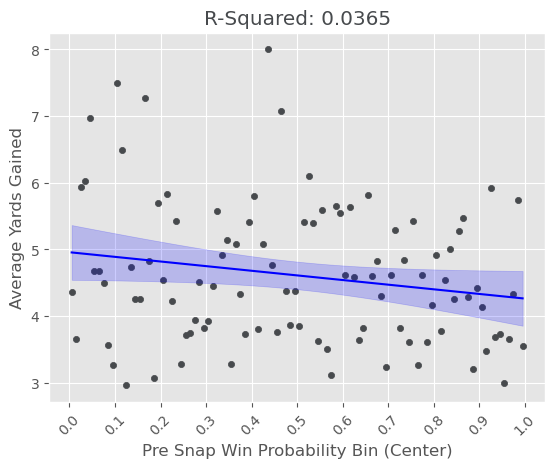

In [14]:
# Bin the win probability by 0.01
df['wp_bin'] = pd.cut(df['pre_snap_wp'], bins=np.arange(0, 1.01, 0.01), include_lowest=True)

# Calculate the average yards gained for each bin
wp_bin_avg = df.groupby('wp_bin').agg({'yards_gained': 'mean'}).reset_index()
wp_bin_avg['bin_center'] = np.arange(0.005, 1.005, 0.01)  # Center of each bin

# Linear regression for best fit line using statsmodels
X = sm.add_constant(wp_bin_avg['bin_center'])  # Add constant for intercept
ols_model = sm.OLS(wp_bin_avg['yards_gained'], X)
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots()

# Scatter plot for average yards gained per bin
ax.scatter(
    wp_bin_avg['bin_center'], 
    wp_bin_avg['yards_gained'], 
    marker='o', 
    color='#474a4d', 
    s=20, 
    label='Binned Average'
)

# Best fit line
y_pred = est.predict(X)
ax.plot(
    wp_bin_avg['bin_center'], 
    y_pred, 
    color='blue', 
    label='Best Fit Line'
)

# Shaded confidence interval
ax.fill_between(
    wp_bin_avg['bin_center'], 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
    label='95% CI'
)

# Plot customization
plt.xlabel('Pre Snap Win Probability Bin (Center)')
plt.ylabel('Average Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.xticks(ticks=np.arange(0, 1.05, 0.1), rotation=45)
plt.grid(True)
plt.gca().set_axisbelow(True)

df.drop(columns=['wp_bin'], inplace=True)

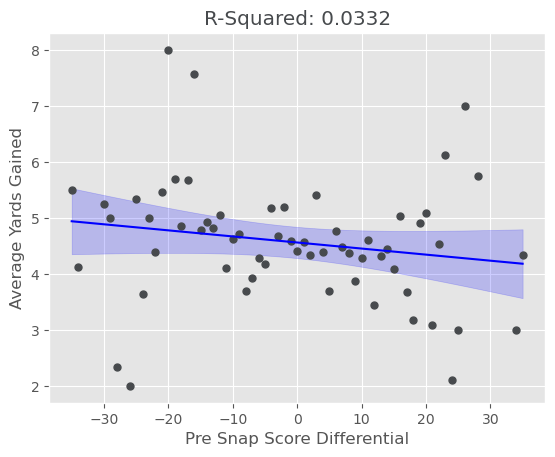

In [15]:
plt.style.use('ggplot')

diff_bin_avg = df.groupby('pre_snap_score_diff').agg({'yards_gained': 'mean'}).reset_index()

# Linear regression for best fit line
X = sm.add_constant(diff_bin_avg['pre_snap_score_diff'])
ols_model = sm.OLS(diff_bin_avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
diff_bin_avg.plot(x='pre_snap_score_diff',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = diff_bin_avg.pre_snap_score_diff.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Pre Snap Score Differential')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

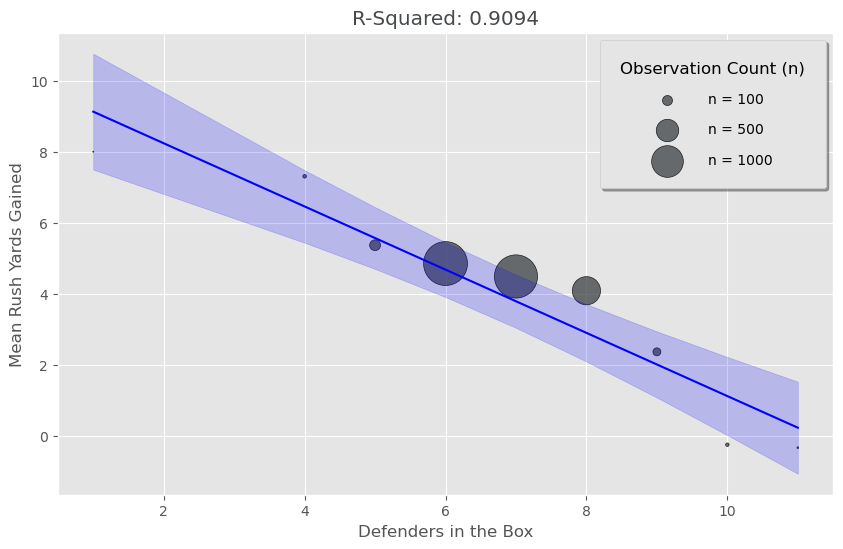

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calculate the average and count for each group of defenders in the box
avgs = df.groupby('defenders_in_box').agg(
    yards_gained_mean=('yards_gained', 'mean'),
    n=('yards_gained', 'size')
).reset_index()

# Linear regression for best fit line
X = sm.add_constant(avgs['defenders_in_box'])
ols_model = sm.OLS(avgs['yards_gained_mean'], X)
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

# Scale marker size based on n (number of observations)
size_scale = 1000  # Adjust for better visualization
marker_sizes = avgs['n'] * size_scale / avgs['n'].max()

# Scatter plot with variable marker sizes
scatter = ax.scatter(
    avgs['defenders_in_box'], 
    avgs['yards_gained_mean'], 
    s=marker_sizes, 
    c='#474a4d', 
    alpha=0.8, 
    edgecolor='black', 
)

# Best fit line
x_pred = avgs['defenders_in_box'].values
y_pred = est.predict(X)
ax.plot(x_pred, y_pred, color='blue')

# Shaded confidence interval
ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
)

# Add a legend for specific values of n
example_ns = [100, 500, 1000]
for example_n in example_ns:
    ax.scatter(
        [], [], 
        s=example_n * size_scale / avgs['n'].max(), 
        c='#474a4d', 
        alpha=0.8, 
        edgecolor='black', 
        label=f"n = {example_n}"
    )

# Customize legend with spacing between lines
legend = plt.legend(
    title='Observation Count (n)', 
    loc='upper right',
    fontsize=10, 
    title_fontsize=12, 
    frameon=True,
    shadow=True,
    handletextpad=2,  # Add spacing between legend text and markers
    borderpad=1.5,    # Add padding around legend box
    labelspacing=1.2  # Add spacing between legend entries
)

# Plot customization
plt.xlabel('Defenders in the Box')
plt.ylabel('Mean Rush Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

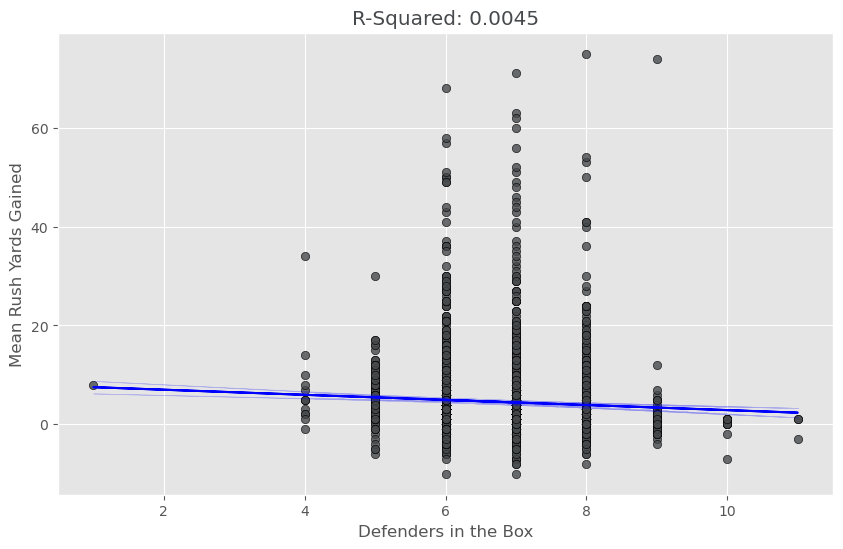

In [17]:
# Linear regression for best fit line
X = sm.add_constant(df['defenders_in_box'])
ols_model = sm.OLS(df['yards_gained'], X)
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with variable marker sizes
scatter = ax.scatter(
    df['defenders_in_box'], 
    df['yards_gained'], 
    c='#474a4d', 
    alpha=0.8, 
    edgecolor='black', 
)

# Best fit line
x_pred = df['defenders_in_box'].values
y_pred = est.predict(X)
ax.plot(x_pred, y_pred, color='blue')

# Shaded confidence interval
ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
)

# Plot customization
plt.xlabel('Defenders in the Box')
plt.ylabel('Mean Rush Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

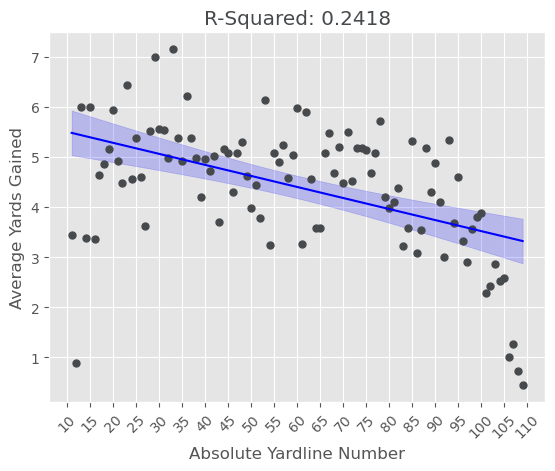

In [18]:
plt.style.use('ggplot')

avg = df.groupby('absolute_yardline_number').agg({'yards_gained': 'mean'}).reset_index()

# Linear regression for best fit line
X = sm.add_constant(avg['absolute_yardline_number'])
ols_model = sm.OLS(avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
avg.plot(x='absolute_yardline_number',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = avg.absolute_yardline_number.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Absolute Yardline Number')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')
plt.xticks(ticks=np.arange(10, 111, 5), rotation=45)

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

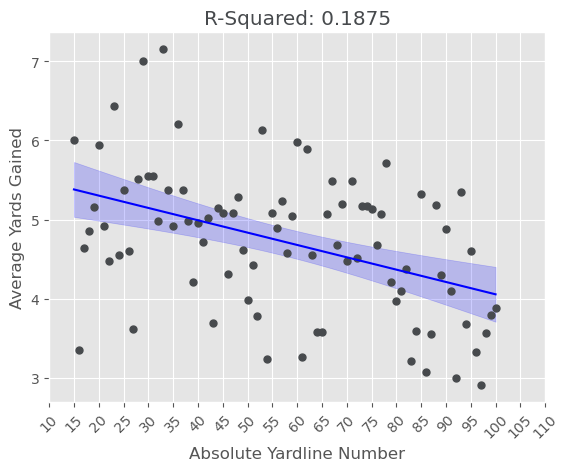

In [19]:
plt.style.use('ggplot')

avg = (
    df
    .query('15 <= absolute_yardline_number <= 100') # filter between 5 and 90 yard lines
    .groupby('absolute_yardline_number')
    .agg({'yards_gained': 'mean'})
    .reset_index()
)

# Linear regression for best fit line
X = sm.add_constant(avg['absolute_yardline_number'])
ols_model = sm.OLS(avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
avg.plot(x='absolute_yardline_number',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = avg.absolute_yardline_number.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Absolute Yardline Number')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')
plt.xticks(ticks=np.arange(10, 111, 5), rotation=45)

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

<Figure size 1200x600 with 0 Axes>

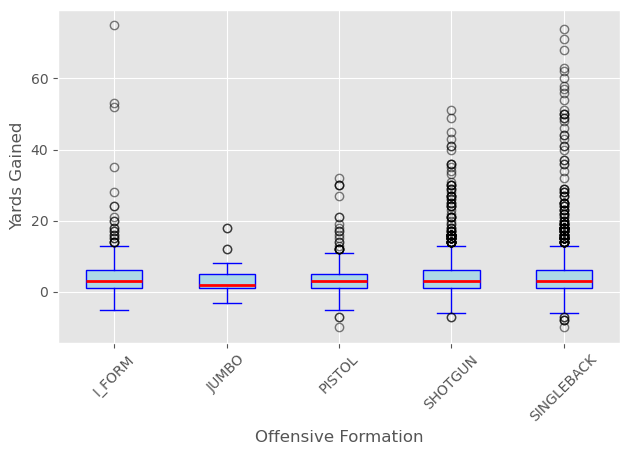

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Generate a boxplot grouped by 'offense_formation' with 'yards_gained' on the y-axis
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.boxplot(
    column='yards_gained',
    by='offense_formation',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Offensive Formation')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
df.groupby('offense_formation').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
offense_formation,,
SHOTGUN,4.690068,60.045662
SINGLEBACK,4.551898,57.759031
I_FORM,4.543897,57.372591
PISTOL,3.966463,61.536585
JUMBO,3.542857,65.142857


<Figure size 1200x600 with 0 Axes>

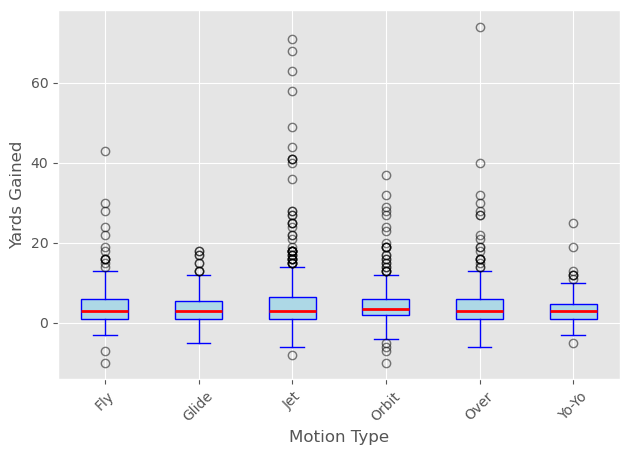

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.query('motion_present').boxplot(
    column='yards_gained',
    by='motion_group',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Motion Type')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
df.groupby('motion_group').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
motion_group,,
Jet,5.092399,57.886736
Orbit,4.586826,57.332335
Over,4.546713,58.775087
Fly,4.420091,58.287671
Glide,3.892216,59.089820
Yo-Yo,3.425373,59.082090


<Figure size 1200x600 with 0 Axes>

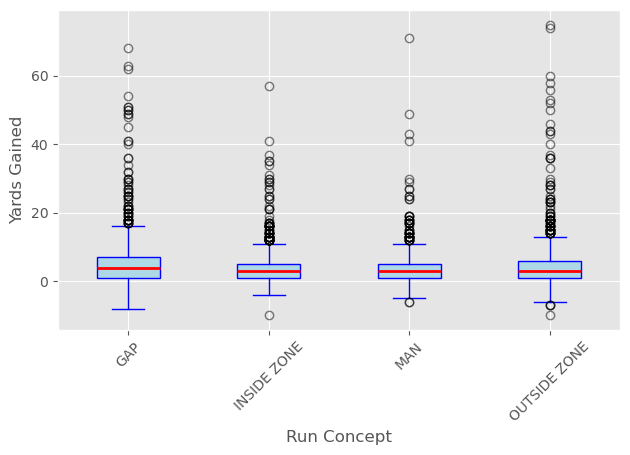

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.boxplot(
    column='yards_gained',
    by='run_concept',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Run Concept')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
df.groupby('run_concept').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
run_concept,,
GAP,5.178881,58.764381
OUTSIDE ZONE,4.473369,56.073236
INSIDE ZONE,4.261058,60.422376
MAN,4.159763,61.911243


In [26]:
df.groupby('motion_present').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
motion_present,,
True,4.597574,58.173649
False,4.527580,59.305922


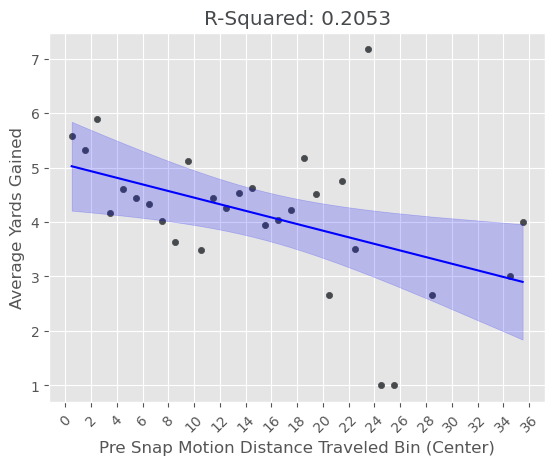

In [27]:
# Bin the win probability by 0.01
df['wp_bin'] = pd.cut(
    df['pre_snap_motion_dist_traveled'], 
    bins=np.arange(
        df['pre_snap_motion_dist_traveled'].min(),
        df['pre_snap_motion_dist_traveled'].max() + 1,
        1
    ),
    include_lowest=True
)

# Calculate the average yards gained for each bin
wp_bin_avg = df.groupby('wp_bin').agg({'yards_gained': 'mean'}).reset_index()
wp_bin_avg['bin_center'] = np.arange(
    df['pre_snap_motion_dist_traveled'].min() + 0.5,
    df['pre_snap_motion_dist_traveled'].max() + 0.5,
    1
)  

# Linear regression for best fit line using statsmodels
X = sm.add_constant(wp_bin_avg['bin_center'])  # Add constant for intercept
ols_model = sm.OLS(wp_bin_avg.loc[~wp_bin_avg['yards_gained'].isna(),'yards_gained'], X[~wp_bin_avg['yards_gained'].isna()])
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X[~wp_bin_avg['yards_gained'].isna()]).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots()

# Scatter plot for average yards gained per bin
ax.scatter(
    wp_bin_avg['bin_center'], 
    wp_bin_avg['yards_gained'], 
    marker='o', 
    color='#474a4d', 
    s=20, 
    label='Binned Average'
)

# Best fit line
y_pred = est.predict(X[~wp_bin_avg['yards_gained'].isna()])
ax.plot(
    wp_bin_avg['bin_center'][~wp_bin_avg['yards_gained'].isna()],
    y_pred, 
    color='blue', 
    label='Best Fit Line'
)

# Shaded confidence interval
ax.fill_between(
    wp_bin_avg.loc[~wp_bin_avg['yards_gained'].isna(),'bin_center'], 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
    label='95% CI'
)

# Plot customization
plt.xlabel('Pre Snap Motion Distance Traveled Bin (Center)')
plt.ylabel('Average Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.xticks(
    ticks=np.arange(
        df['pre_snap_motion_dist_traveled'].min(),
        df['pre_snap_motion_dist_traveled'].max() + 1,
        2
    ), 
    rotation=45
)
plt.grid(True)
plt.gca().set_axisbelow(True)

df.drop(columns=['wp_bin'], inplace=True)

<Figure size 1200x600 with 0 Axes>

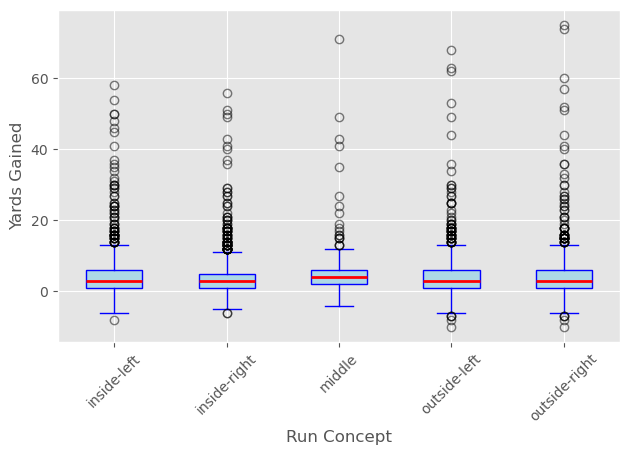

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.boxplot(
    column='yards_gained',
    by='play_dir_location',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Run Concept')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
df.groupby('play_dir_location').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
play_dir_location,,
middle,5.099237,58.091603
outside-right,4.670455,57.139773
inside-left,4.662319,59.778986
outside-left,4.391039,58.401222
inside-right,4.369170,59.626877


In [30]:
df.groupby('down').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
down,,
1,4.656796,57.596861
2,4.440895,59.491374
3,4.349727,64.606557
4,3.542857,73.771429


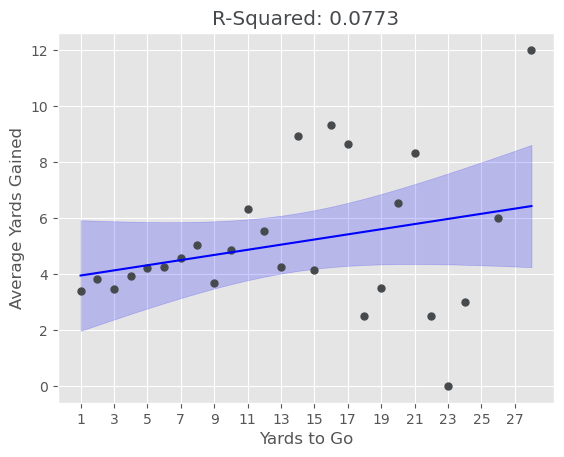

In [31]:
plt.style.use('ggplot')

avg = (
    df
    # .query('15 <= absolute_yardline_number <= 100') # filter between 5 and 90 yard lines
    .groupby('yards_to_go')
    .agg({'yards_gained': 'mean'})
    .reset_index()
)

# Linear regression for best fit line
X = sm.add_constant(avg['yards_to_go'])
ols_model = sm.OLS(avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
avg.plot(x='yards_to_go',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = avg.yards_to_go.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Yards to Go')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')
plt.xticks(
    ticks=np.arange(
        df['yards_to_go'].min(),
        df['yards_to_go'].max() + 1,
        2
    ), 
    rotation=0
)

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

# Model Creation

In [270]:
# filter between 5 and 90 yard lines
df = df.query('15 <= absolute_yardline_number <= 100').reset_index(drop=True)

In [271]:
avg_yards_gained_by_def_in_box = (
    df
    .groupby('defenders_in_box')
    .agg({'yards_gained': 'mean'})
    .reset_index()
)

X = sm.add_constant(avg_yards_gained_by_def_in_box['defenders_in_box'])
ols_model = sm.OLS(avg_yards_gained_by_def_in_box['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

# map predicitons ot defenders_in_box
avg_yards_gained_by_def_in_box['y_pred'] = est.predict(X)

df['avg_yards_gained_by_def_in_box'] = df['defenders_in_box'].map(avg_yards_gained_by_def_in_box.set_index('defenders_in_box')['y_pred'])

df['run_loc'] = np.where(
    df.play_dir_location.isin(['outside-right', 'outside-left']),
    'outside',
    np.where(
        df.play_dir_location.isin(['inside-right', 'inside-left']),
        'inside',
        'middle'
    )
)

In [272]:
df.head()

,game_play_id,week,run_concept,play_dir_location,motion_had_rush_attempt,pre_snap_motion_dist_traveled,motion_group,motion_present,motion_towards_playside,down,yards_to_go,absolute_yardline_number,offense_formation,defenders_in_box,pre_snap_score_diff,pre_snap_wp,yards_gained,off_run_str,def_run_str,avg_yards_gained_by_def_in_box,run_loc
0,2022091105_3712,1,OUTSIDE ZONE,inside-right,NaN,NaN,NaN,False,NaN,1,10,81,SINGLEBACK,6.0,-7,0.221582,14,1.392308,0.072716,4.711683,inside
1,2022091104_1094,1,OUTSIDE ZONE,outside-right,0.0,0.697350,Jet,True,1.0,1,10,35,SINGLEBACK,7.0,0,0.395236,1,0.185314,0.570660,3.784595,outside
2,2022091101_3923,1,INSIDE ZONE,middle,NaN,NaN,NaN,False,NaN,2,11,95,SINGLEBACK,8.0,-2,0.741719,0,-0.661682,-0.660546,2.857507,middle
3,2022091106_1380,1,INSIDE ZONE,inside-right,0.0,8.234742,Orbit,True,1.0,1,10,18,I_FORM,7.0,10,0.847051,1,-0.984893,-0.440877,3.784595,inside
4,2022091100_501,1,OUTSIDE ZONE,outside-left,0.0,9.052830,Orbit,True,1.0,1,10,33,SINGLEBACK,6.0,-3,0.618278,5,-0.743291,-0.431272,4.711683,outside


In [274]:
n_cores = multiprocessing.cpu_count()

df = df.reset_index(drop=True)

# Define features
features = ['absolute_yardline_number', 'avg_yards_gained_by_def_in_box', 'motion_present', 
            'pre_snap_wp', 'yards_to_go', 'down', 'run_concept', 'run_loc', 'offense_formation',
            'motion_group', 'motion_had_rush_attempt', 'pre_snap_motion_dist_traveled', 'motion_towards_playside',
            'off_run_str', 'def_run_str']
X = df[features].copy()
y = df[['yards_gained']].copy()

down_enc = pd.get_dummies(X['down'], prefix='down')
X = pd.concat([X, down_enc], axis=1)
X.drop(columns='down', inplace=True)

# ['OUTSIDE ZONE', 'INSIDE ZONE', 'GAP', 'MAN']
run_concept_enc = pd.get_dummies(X['run_concept'], prefix='run_concept')
X = pd.concat([X, run_concept_enc], axis=1)
X.drop(columns='run_concept', inplace=True)

run_loc_enc = pd.get_dummies(X['run_loc'], prefix='run_loc')
X = pd.concat([X, run_loc_enc], axis=1)
X.drop(columns='run_loc', inplace=True)

# ['SINGLEBACK', 'I_FORM', 'SHOTGUN', 'PISTOL', 'JUMBO']
offensive_formation_enc = pd.get_dummies(X['offense_formation'], prefix='offense_formation')
X = pd.concat([X, offensive_formation_enc], axis=1)
X.drop(columns='offense_formation', inplace=True)

# Create interaction terms between 'yards_to_go' and down variables
X['yards_to_go_down_1'] = X['yards_to_go'] * X['down_1']
X['yards_to_go_down_2'] = X['yards_to_go'] * X['down_2']
X['yards_to_go_down_3'] = X['yards_to_go'] * X['down_3']
X['yards_to_go_down_4'] = X['yards_to_go'] * X['down_4']

# Interaction between 'run_loc' and 'yards_to_go'
X['run_loc_outside_yards_to_go'] = X['run_loc_outside'] * X['yards_to_go']
X['run_loc_inside_yards_to_go'] = X['run_loc_inside'] * X['yards_to_go']
X['run_loc_middle_yards_to_go'] = X['run_loc_middle'] * X['yards_to_go']

# Motion groups: ['None', 'Jet', 'Orbit', 'Yo-Yo', 'Fly', 'Glide', 'Over']
X['motion_group'] = X['motion_group'].replace(np.nan, 'None')
motion_group_enc = pd.get_dummies(X['motion_group'], prefix='motion_group')
X = pd.concat([X, motion_group_enc], axis=1)

# Create Interaction terms between 'motion_group' and 'run_concept'
# Jet Motions
X['man_run_concept_with_jet_motion'] = X['run_concept_MAN'] * X['motion_group_Jet']
X['gap_run_concept_with_jet_motion'] = X['run_concept_GAP'] * X['motion_group_Jet']
X['outside_zone_run_concept_with_jet_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Jet']
X['inside_zone_run_concept_with_jet_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Jet']
# Orbit Motions
X['man_run_concept_with_orbit_motion'] = X['run_concept_MAN'] * X['motion_group_Orbit']
X['gap_run_concept_with_orbit_motion'] = X['run_concept_GAP'] * X['motion_group_Orbit']
X['outside_zone_run_concept_with_orbit_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Orbit']
X['inside_zone_run_concept_with_orbit_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Orbit']
# Yo-Yo Motions
X['man_run_concept_with_yo_yo_motion'] = X['run_concept_MAN'] * X['motion_group_Yo-Yo']
X['gap_run_concept_with_yo_yo_motion'] = X['run_concept_GAP'] * X['motion_group_Yo-Yo']
X['outside_zone_run_concept_with_yo_yo_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Yo-Yo']
X['inside_zone_run_concept_with_yo_yo_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Yo-Yo']
# Fly Motions
X['man_run_concept_with_fly_motion'] = X['run_concept_MAN'] * X['motion_group_Fly']
X['gap_run_concept_with_fly_motion'] = X['run_concept_GAP'] * X['motion_group_Fly']
X['outside_zone_run_concept_with_fly_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Fly']
X['inside_zone_run_concept_with_fly_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Fly']
# Glide Motions
X['man_run_concept_with_glide_motion'] = X['run_concept_MAN'] * X['motion_group_Glide']
X['gap_run_concept_with_glide_motion'] = X['run_concept_GAP'] * X['motion_group_Glide']
X['outside_zone_run_concept_with_glide_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Glide']
X['inside_zone_run_concept_with_glide_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Glide']
# Over Motions
X['man_run_concept_with_over_motion'] = X['run_concept_MAN'] * X['motion_group_Over']
X['gap_run_concept_with_over_motion'] = X['run_concept_GAP'] * X['motion_group_Over']
X['outside_zone_run_concept_with_over_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Over']
X['inside_zone_run_concept_with_over_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Over']

# Fill missing values in 'motion_had_rush_attempt' with 0
X['motion_had_rush_attempt'] = X['motion_had_rush_attempt'].fillna(0).astype(int)

# Encode 'motion_towards_playside' as binary
X['motion_towards_playside'] = X['motion_towards_playside'] == 1
X['motion_towards_backside'] = X['motion_towards_playside'] == -1
X['motion_on_middle_run'] = X['motion_towards_playside'] == 0

# Fill missing values in 'pre_snap_motion_dist_traveled' with 0
X['pre_snap_motion_dist_traveled'] = X['pre_snap_motion_dist_traveled'].fillna(0)
 
# Bayesian model
with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Absolute yardline number
    yardline_coeff = pm.Normal('yardline', mu=0, sigma=1)

    # Average yards gained by defenders in the box
    defenders_in_box_coeff = pm.Normal('avg_yards_gained_by_def_in_box', mu=0, sigma=1)

    # Pre snap win probability
    pre_snap_wp_coeff = pm.Normal('pre_snap_wp', mu=0, sigma=1)

    # Down coefficients
    down_1_coeff = pm.Normal('down_1', mu=0, sigma=1)
    down_2_coeff = pm.Normal('down_2', mu=0, sigma=1)
    down_3_coeff = pm.Normal('down_3', mu=0, sigma=1)
    down_4_coeff = pm.Normal('down_4', mu=0, sigma=1)

    # Yards to go for first down
    yards_to_go_coeff = pm.Normal('yards_to_go', mu=0, sigma=1)

    # Yards to go interaction with down
    yards_to_go_down_1_coeff = pm.Normal('yards_to_go_down_1', mu=0, sigma=1)
    yards_to_go_down_2_coeff = pm.Normal('yards_to_go_down_2', mu=0, sigma=1)
    yards_to_go_down_3_coeff = pm.Normal('yards_to_go_down_3', mu=0, sigma=1)
    yards_to_go_down_4_coeff = pm.Normal('yards_to_go_down_4', mu=0, sigma=1)

    # Run concepts
    man_run_concept_coeff = pm.Normal('run_concept_MAN', mu=0, sigma=1)
    gap_run_concept_coeff = pm.Normal('run_concept_GAP', mu=0, sigma=1)
    outside_zone_run_concept_coeff = pm.Normal('run_concept_OUTSIDE ZONE', mu=0, sigma=1)
    inside_zone_run_concept_coeff = pm.Normal('run_concept_INSIDE ZONE', mu=0, sigma=1)

    # Run location
    run_loc_outside = pm.Normal('run_loc_outside', mu=0, sigma=1)
    run_loc_inside = pm.Normal('run_loc_inside', mu=0, sigma=1)
    run_loc_middle = pm.Normal('run_loc_middle', mu=0, sigma=1)

    # Run location interaction with yards to go
    run_loc_outside_yards_to_go = pm.Normal('run_loc_outside_yards_to_go', mu=0, sigma=1)
    run_loc_inside_yards_to_go = pm.Normal('run_loc_inside_yards_to_go', mu=0, sigma=1)
    run_loc_middle_yards_to_go = pm.Normal('run_loc_middle_yards_to_go', mu=0, sigma=1)

    # Offensive formations
    off_formation_SINGLEBACK = pm.Normal('offense_formation_SINGLEBACK', mu=0, sigma=1)
    off_formation_I_FORM = pm.Normal('offense_formation_I_FORM', mu=0, sigma=1)
    off_formation_SHOTGUN = pm.Normal('offense_formation_SHOTGUN', mu=0, sigma=1)
    off_formation_PISTOL = pm.Normal('offense_formation_PISTOL', mu=0, sigma=1)
    off_formation_JUMBO = pm.Normal('offense_formation_JUMBO', mu=0, sigma=1)

    # Motion groups
    motion_group_Jet = pm.Normal('motion_group_Jet', mu=0, sigma=1)
    motion_group_Orbit = pm.Normal('motion_group_Orbit', mu=0, sigma=1)
    motion_group_Yo_Yo = pm.Normal('motion_group_Yo_Yo', mu=0, sigma=1)
    motion_group_Fly = pm.Normal('motion_group_Fly', mu=0, sigma=1)
    motion_group_Glide = pm.Normal('motion_group_Glide', mu=0, sigma=1)
    motion_group_Over = pm.Normal('motion_group_Over', mu=0, sigma=1)
    
    # Jet motion interaction with run concepts
    man_run_concept_with_jet_motion_coeff = pm.Normal('man_run_concept_with_jet_motion', mu=0, sigma=1)
    gap_run_concept_with_jet_motion_coeff = pm.Normal('gap_run_concept_with_jet_motion', mu=0, sigma=1)
    outside_zone_run_concept_with_jet_motion_coeff = pm.Normal('outside_zone_run_concept_with_jet_motion', mu=0, sigma=1)
    inside_zone_run_concept_with_jet_motion_coeff = pm.Normal('inside_zone_run_concept_with_jet_motion',mu=0, sigma=1)

    # Orbit motion interaction with run concepts
    man_run_concept_with_orbit_motion_coeff = pm.Normal('man_run_concept_with_orbit_motion',mu=0, sigma=1)
    gap_run_concept_with_orbit_motion_coeff = pm.Normal('gap_run_concept_with_orbit_motion',mu=0, sigma=1)
    outside_zone_run_concept_with_orbit_motion_coeff = pm.Normal('outside_zone_run_concept_with_orbit_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_orbit_motion_coeff = pm.Normal('inside_zone_run_concept_with_orbit_motion',mu=0, sigma=1)

    # Yo-Yo motion interaction with run concepts
    man_run_concept_with_yo_yo_motion_coeff = pm.Normal('man_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    gap_run_concept_with_yo_yo_motion_coeff = pm.Normal('gap_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    outside_zone_run_concept_with_yo_yo_motion_coeff = pm.Normal('outside_zone_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_yo_yo_motion_coeff = pm.Normal('inside_zone_run_concept_with_yo_yo_motion',mu=0, sigma=1)

    # Fly motion interaction with run concepts
    man_run_concept_with_fly_motion_coeff = pm.Normal('man_run_concept_with_fly_motion',mu=0, sigma=1)
    gap_run_concept_with_fly_motion_coeff = pm.Normal('gap_run_concept_with_fly_motion',mu=0, sigma=1)
    outside_zone_run_concept_with_fly_motion_coeff = pm.Normal('outside_zone_run_concept_with_fly_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_fly_motion_coeff = pm.Normal('inside_zone_run_concept_with_fly_motion',mu=0, sigma=1)

    # Glide motion interaction with run concepts
    man_run_concept_with_glide_motion_coeff = pm.Normal('man_run_concept_with_glide_motion',mu=0, sigma=1)
    gap_run_concept_with_glide_motion_coeff = pm.Normal('gap_run_concept_with_glide_motion',mu=0, sigma=1)
    outside_zone_run_concept_with_glide_motion_coeff = pm.Normal('outside_zone_run_concept_with_glide_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_glide_motion_coeff = pm.Normal('inside_zone_run_concept_with_glide_motion',mu=0, sigma=1)

    # Over motion interaction with run concepts
    man_run_concept_with_over_motion_coeff = pm.Normal('man_run_concept_with_over_motion',mu=0, sigma=1)
    gap_run_concept_with_over_motion_coeff = pm.Normal('gap_run_concept_with_over_motion',mu=0, sigma=1)
    outside_zone_run_concept_with_over_motion_coeff = pm.Normal('outside_zone_run_concept_with_over_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_over_motion_coeff = pm.Normal('inside_zone_run_concept_with_over_motion',mu=0, sigma=1)

    # Motion had rush attempt
    motion_had_rush_attempt_coeff = pm.Normal('motion_had_rush_attempt', mu=0, sigma=1)

    # Motion towards/away from playside
    motion_towards_playside_coeff = pm.Normal('motion_towards_playside', mu=0, sigma=1)
    motion_towards_backside_coeff = pm.Normal('motion_towards_backside', mu=0, sigma=1)
    motion_on_middle_run_coeff = pm.Normal('motion_on_middle_run', mu=0, sigma=1)

    # Pre snap motion distance traveled
    pre_snap_motion_dist_traveled_coeff = pm.Normal('pre_snap_motion_dist_traveled', mu=0, sigma=1)

    # Offensive Run Grade Prev 10 Games
    off_run_strength_prev_10_games = pm.Normal('off_run_strength_prev_10_games', mu=0, sigma=1)

    # Defensive Run Grade Prev 10 Games
    def_run_strength_prev_10_games = pm.Normal('def_run_strength_prev_10_games', mu=0, sigma=1)
       
    mu = (
        intercept + 
        yardline_coeff * X['absolute_yardline_number'] +
        defenders_in_box_coeff * X['avg_yards_gained_by_def_in_box'] +
        pre_snap_wp_coeff * X['pre_snap_wp'] +

        # Down coefficients
        down_1_coeff * X['down_1'] +
        down_2_coeff * X['down_2'] +
        down_3_coeff * X['down_3'] +
        down_4_coeff * X['down_4'] +

        # Yards to go for first down
        yards_to_go_coeff * X['yards_to_go'] +

        # Yards to go interaction with down
        yards_to_go_down_1_coeff * X['yards_to_go_down_1'] +
        yards_to_go_down_2_coeff * X['yards_to_go_down_2'] +
        yards_to_go_down_3_coeff * X['yards_to_go_down_3'] +
        yards_to_go_down_4_coeff * X['yards_to_go_down_4'] +

        # Run concepts
        man_run_concept_coeff * X['run_concept_MAN'] +
        gap_run_concept_coeff * X['run_concept_GAP'] +
        outside_zone_run_concept_coeff * X['run_concept_OUTSIDE ZONE'] +
        inside_zone_run_concept_coeff * X['run_concept_INSIDE ZONE'] +

        # Run location
        run_loc_outside * X['run_loc_outside'] +
        run_loc_inside * X['run_loc_inside'] +
        run_loc_middle * X['run_loc_middle'] +

        # run location interaction with yards to go
        run_loc_outside_yards_to_go * X['run_loc_outside_yards_to_go'] +
        run_loc_inside_yards_to_go * X['run_loc_inside_yards_to_go'] +
        run_loc_middle_yards_to_go * X['run_loc_middle_yards_to_go'] +

        # Offensive formations
        off_formation_SINGLEBACK * X['offense_formation_SINGLEBACK'] +
        off_formation_I_FORM * X['offense_formation_I_FORM'] +
        off_formation_SHOTGUN * X['offense_formation_SHOTGUN'] +
        off_formation_PISTOL * X['offense_formation_PISTOL'] +
        off_formation_JUMBO * X['offense_formation_JUMBO'] +

        # Motion groups
        motion_group_Jet * X['motion_group_Jet'] +
        motion_group_Orbit * X['motion_group_Orbit'] +
        motion_group_Yo_Yo * X['motion_group_Yo-Yo'] +
        motion_group_Fly * X['motion_group_Fly'] +
        motion_group_Glide * X['motion_group_Glide'] +
        motion_group_Over * X['motion_group_Over'] +

        # Jet motion interaction with run concepts
        man_run_concept_with_jet_motion_coeff * X['man_run_concept_with_jet_motion'] +
        gap_run_concept_with_jet_motion_coeff * X['gap_run_concept_with_jet_motion'] +
        outside_zone_run_concept_with_jet_motion_coeff * X['outside_zone_run_concept_with_jet_motion'] +
        inside_zone_run_concept_with_jet_motion_coeff * X['inside_zone_run_concept_with_jet_motion'] +

        # Orbit motion interaction with run concepts
        man_run_concept_with_orbit_motion_coeff * X['man_run_concept_with_orbit_motion'] +
        gap_run_concept_with_orbit_motion_coeff * X['gap_run_concept_with_orbit_motion'] +
        outside_zone_run_concept_with_orbit_motion_coeff * X['outside_zone_run_concept_with_orbit_motion'] +
        inside_zone_run_concept_with_orbit_motion_coeff * X['inside_zone_run_concept_with_orbit_motion'] +

        # Yo-Yo motion interaction with run concepts
        man_run_concept_with_yo_yo_motion_coeff * X['man_run_concept_with_yo_yo_motion'] +
        gap_run_concept_with_yo_yo_motion_coeff * X['gap_run_concept_with_yo_yo_motion'] +
        outside_zone_run_concept_with_yo_yo_motion_coeff * X['outside_zone_run_concept_with_yo_yo_motion'] +
        inside_zone_run_concept_with_yo_yo_motion_coeff * X['inside_zone_run_concept_with_yo_yo_motion'] +

        # Fly motion interaction with run concepts
        man_run_concept_with_fly_motion_coeff * X['man_run_concept_with_fly_motion'] +
        gap_run_concept_with_fly_motion_coeff * X['gap_run_concept_with_fly_motion'] +
        outside_zone_run_concept_with_fly_motion_coeff * X['outside_zone_run_concept_with_fly_motion'] +
        inside_zone_run_concept_with_fly_motion_coeff * X['inside_zone_run_concept_with_fly_motion'] +

        # Glide motion interaction with run concepts
        man_run_concept_with_glide_motion_coeff * X['man_run_concept_with_glide_motion'] +
        gap_run_concept_with_glide_motion_coeff * X['gap_run_concept_with_glide_motion'] +
        outside_zone_run_concept_with_glide_motion_coeff * X['outside_zone_run_concept_with_glide_motion'] +
        inside_zone_run_concept_with_glide_motion_coeff * X['inside_zone_run_concept_with_glide_motion'] +

        # Over motion interaction with run concepts
        man_run_concept_with_over_motion_coeff * X['man_run_concept_with_over_motion'] +
        gap_run_concept_with_over_motion_coeff * X['gap_run_concept_with_over_motion'] +
        outside_zone_run_concept_with_over_motion_coeff * X['outside_zone_run_concept_with_over_motion'] +
        inside_zone_run_concept_with_over_motion_coeff * X['inside_zone_run_concept_with_over_motion'] +

        # Motion had rush attempt
        motion_had_rush_attempt_coeff * X['motion_had_rush_attempt'] +

        # Motion towards/away from playside
        motion_towards_playside_coeff * X['motion_towards_playside'] +
        motion_towards_backside_coeff * X['motion_towards_backside'] +
        motion_on_middle_run_coeff * X['motion_on_middle_run'] +

        # Pre snap motion distance traveled
        pre_snap_motion_dist_traveled_coeff * X['pre_snap_motion_dist_traveled'] +

        # Offensive Run Grade Prev 10 Games
        off_run_strength_prev_10_games * X['off_run_str'] +

        # Defensive Run Grade Prev 10 Games
        def_run_strength_prev_10_games * X['def_run_str']
    )

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    yp = pm.Normal('yards_gained', mu=mu, sigma=sigma, observed=y['yards_gained'])

    # Sample
    trace = pm.sample_smc(
        draws=2000,  # Number of posterior samples
        return_inferencedata=True,  # Return results as an ArviZ InferenceData object
        idata_kwargs={'log_likelihood': True},  # Include log likelihood
        chains=4,  # Number of independent chains
        cores=n_cores,  # Number of CPU cores to use
        parallel=True,  # Enable parallel computation
        progressbar=True  # Show progress bar during sampling
    )

# Summarize results
az.summary(trace)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.245,0.827,-0.291,2.801,0.009,0.007,8061.0,7489.0,1.0
yardline,-0.014,0.005,-0.022,-0.005,0.000,0.000,7898.0,7767.0,1.0
avg_yards_gained_by_def_in_box,0.326,0.139,0.064,0.579,0.002,0.001,7650.0,7872.0,1.0
pre_snap_wp,-0.395,0.332,-1.005,0.247,0.004,0.003,8324.0,7604.0,1.0
down_1,0.266,0.783,-1.225,1.684,0.009,0.006,8074.0,8012.0,1.0
down_2,0.625,0.630,-0.599,1.771,0.007,0.005,7759.0,8087.0,1.0
down_3,0.075,0.653,-1.131,1.327,0.007,0.005,7876.0,7367.0,1.0
down_4,0.272,0.867,-1.335,1.922,0.010,0.007,8107.0,7772.0,1.0
yards_to_go,0.123,0.612,-1.060,1.223,0.007,0.005,7926.0,7531.0,1.0
yards_to_go_down_1,-0.019,0.488,-0.907,0.918,0.005,0.004,7955.0,8072.0,1.0


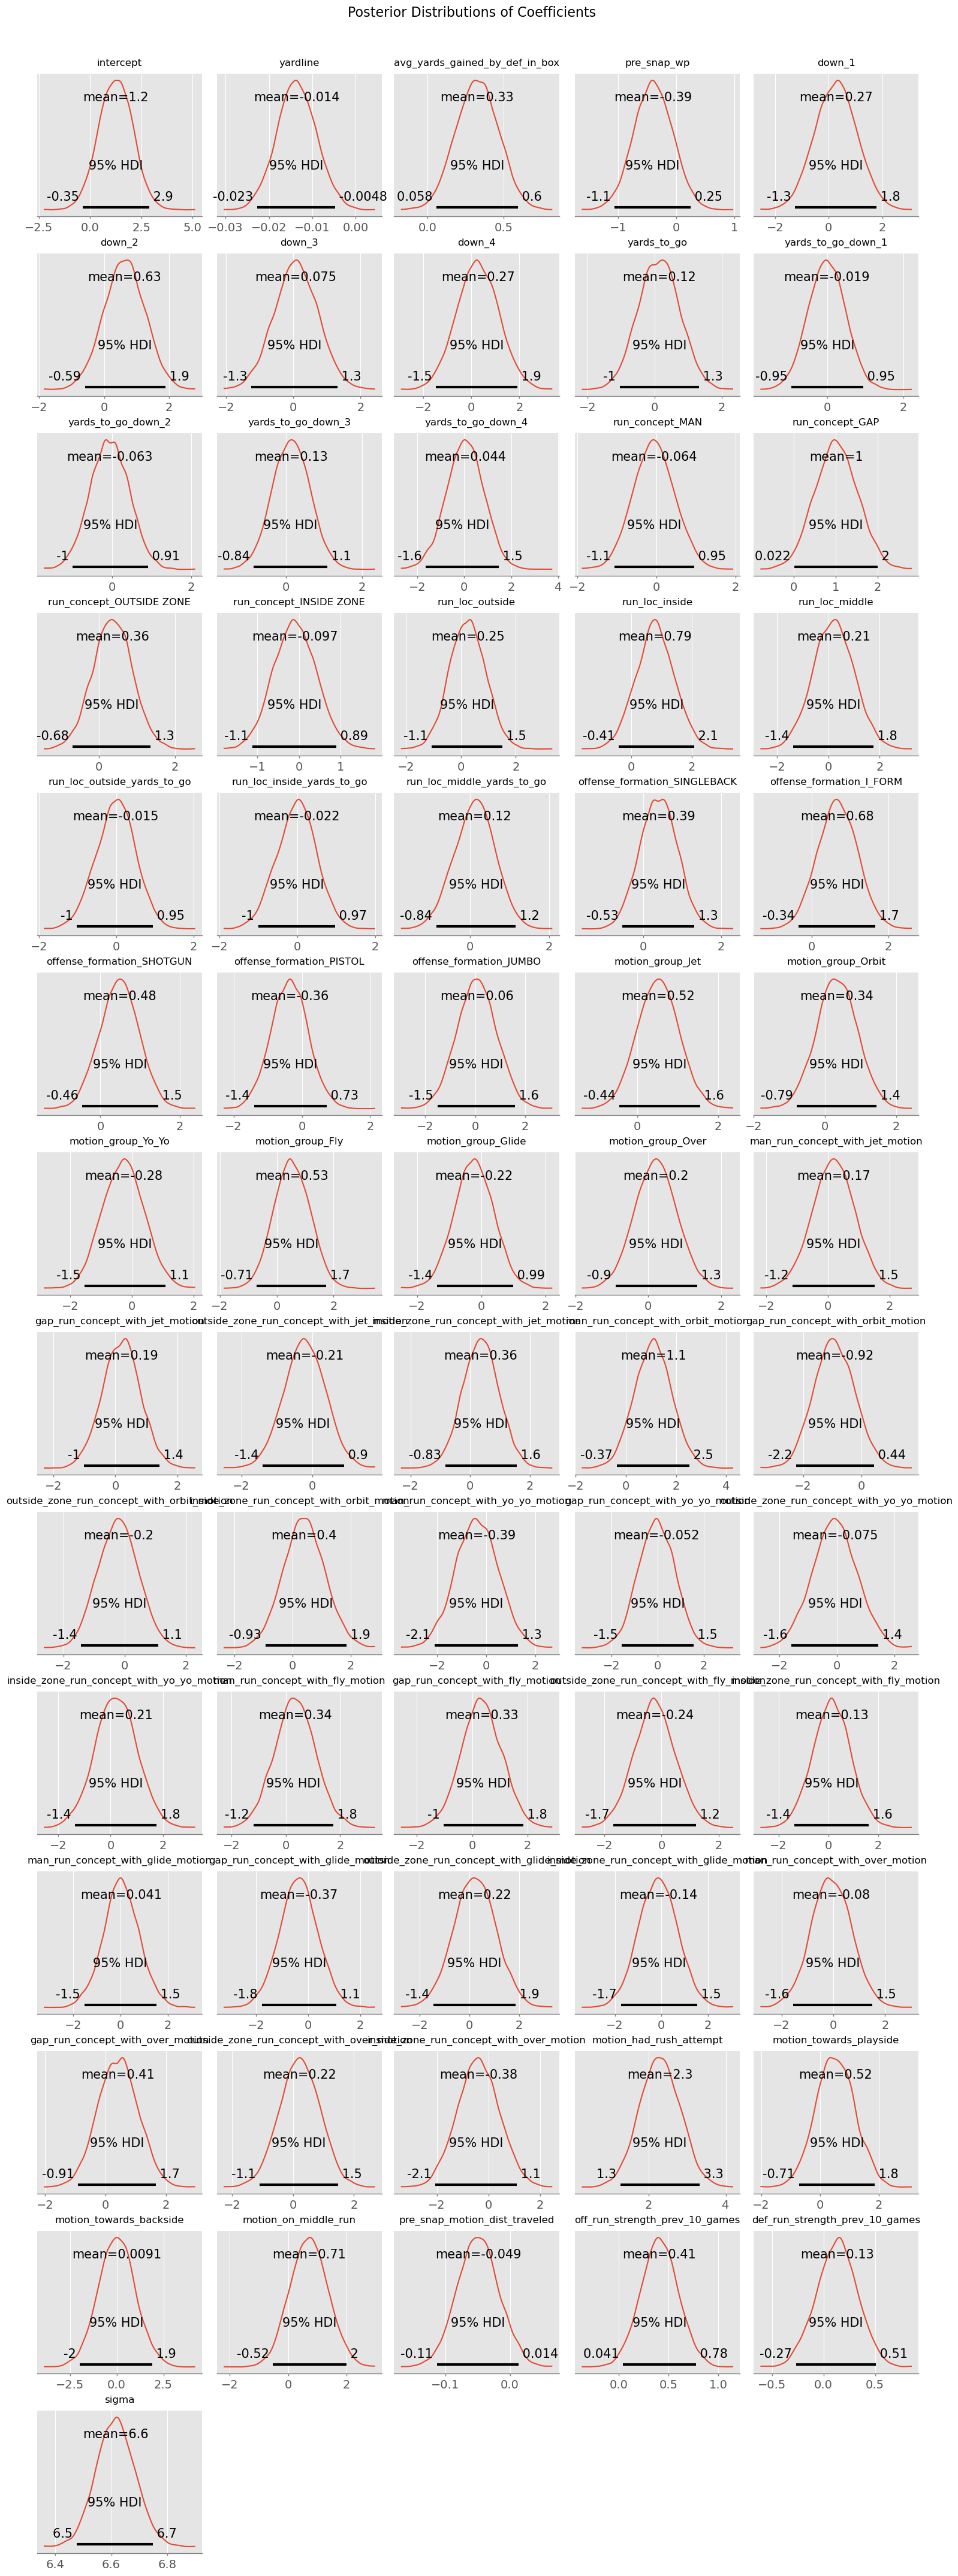

In [275]:
import arviz as az
import matplotlib.pyplot as plt
import math

# Visualize the distributions of each coefficient
coefficients = list(trace.posterior.data_vars)
posterior_samples = trace.posterior

# Create subplots for each coefficient
n_cols = 5
n_rows = math.ceil(len(coefficients) / n_cols)
fig_width = n_cols * 3
fig_height = n_rows * 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), constrained_layout=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each coefficient
for ax, coeff in zip(axes, coefficients):
    # Plot the posterior distribution
    az.plot_posterior(posterior_samples[coeff], ax=ax, hdi_prob=0.95)
    
    # Set the title to the coefficient name
    ax.set_title(coeff, fontsize=12, pad=10)

# Hide any unused subplots
for ax in axes[len(coefficients):]:
    ax.axis('off')

# Display the plots
plt.suptitle('Posterior Distributions of Coefficients', fontsize=16, y=1.02)
plt.show()

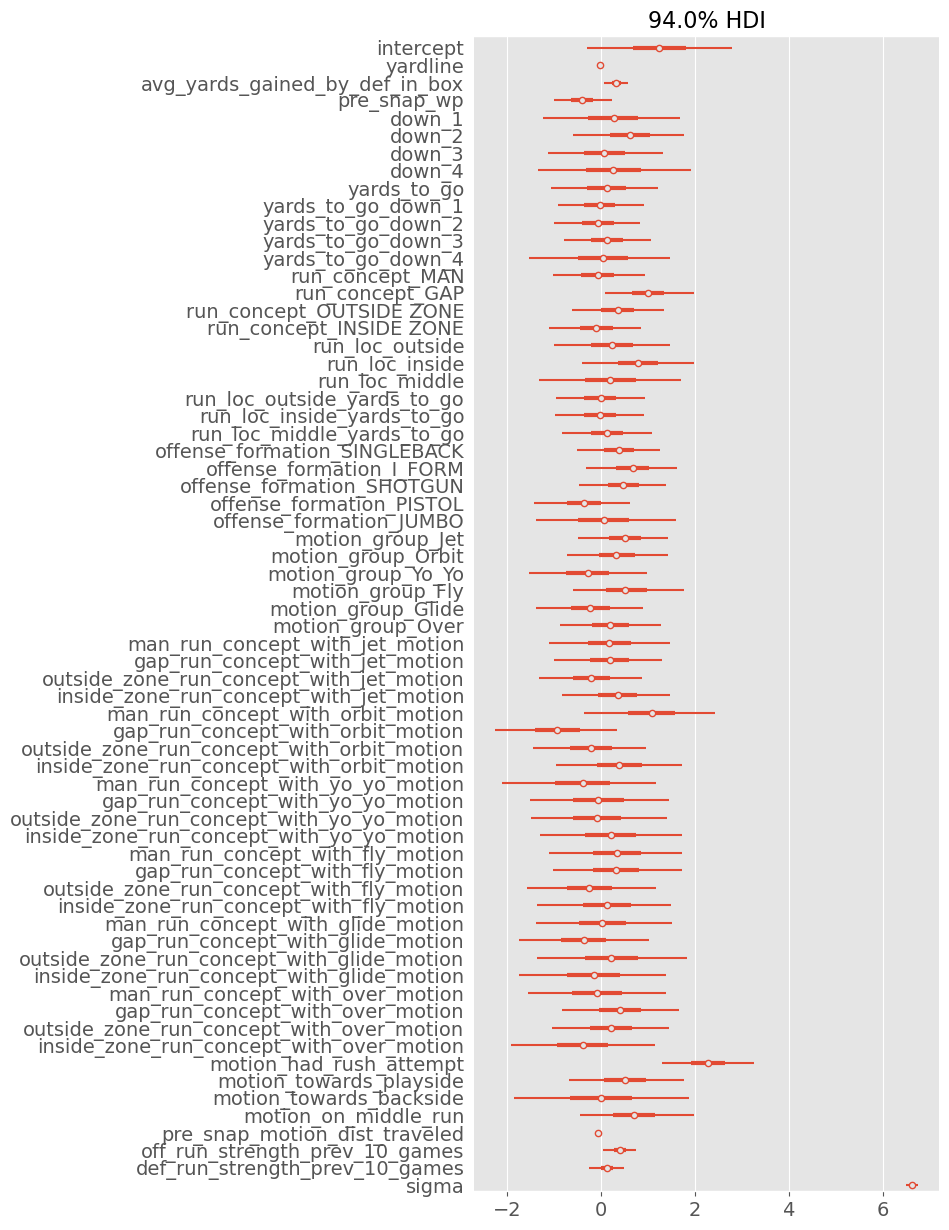

In [276]:
az.plot_forest(trace, figsize=(6, 15), combined=True)
plt.show()

In [277]:
with model:
    y_pred_trace = pm.sample_posterior_predictive(trace)

y_pred = y_pred_trace.posterior_predictive["yards_gained"].mean(axis=0).mean(axis=0).values
y_obs = y["yards_gained"].values

r_squared = 1 - (np.var(y_obs - y_pred) / np.var(y_obs))
print(f"Bayesian R^2: {r_squared:.5f}")

Sampling: [yards_gained]


Output()

Bayesian R^2: 0.02264


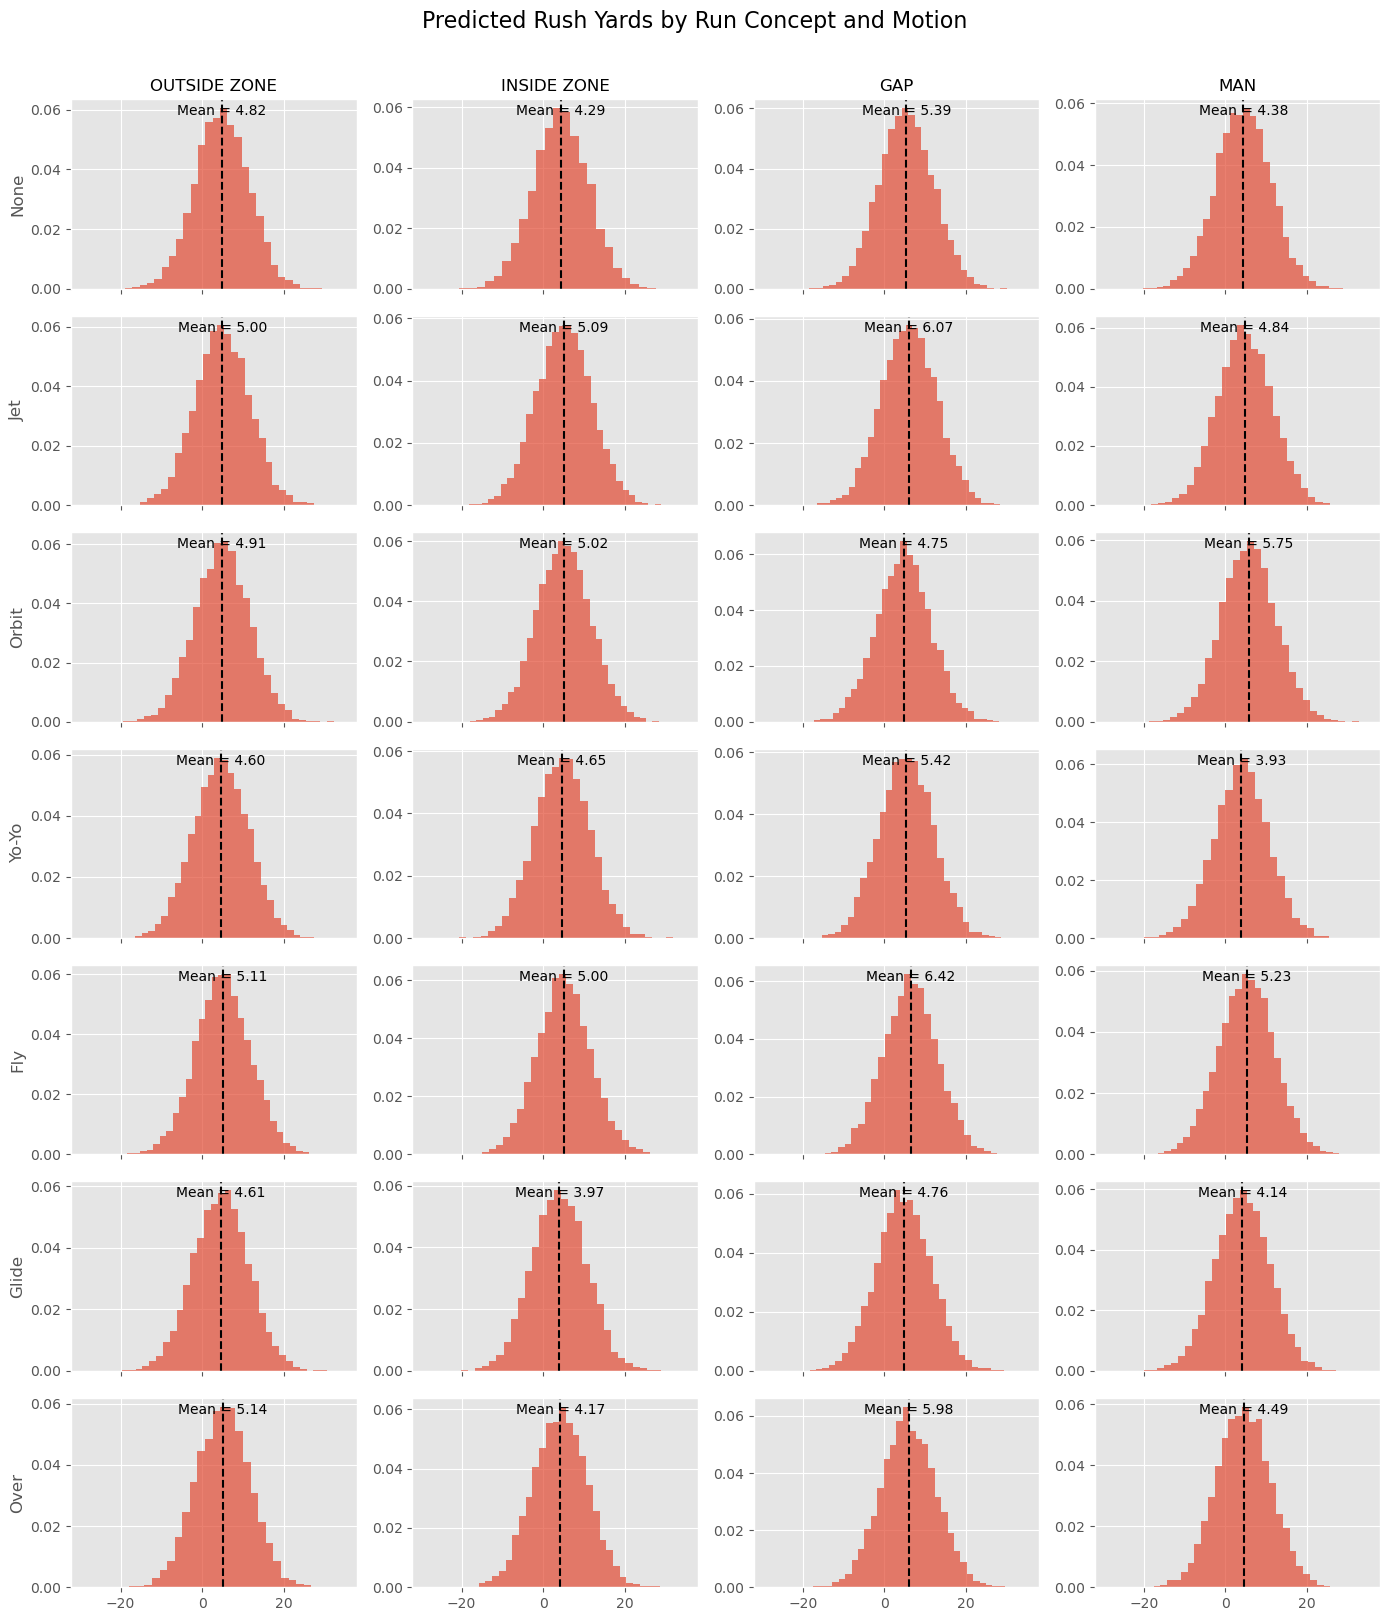

In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

############################################
# 1) Create a "baseline" feature dictionary
############################################
baseline_dict = {
    'absolute_yardline_number': 30,
    'avg_yards_gained_by_def_in_box': avg_yards_gained_by_def_in_box.query('defenders_in_box == 6')['y_pred'].values[0],
    'pre_snap_wp': 0.5,
    'yards_to_go': 10,

    # Down dummy columns
    'down_1': 1,
    'down_2': 0,
    'down_3': 0,
    'down_4': 0,
    # Interaction
    'yards_to_go_down_1': 10,   # 10 * 1
    'yards_to_go_down_2': 0,
    'yards_to_go_down_3': 0,
    'yards_to_go_down_4': 0,

    # Run concepts
    'run_concept_MAN': 0,
    'run_concept_GAP': 0,
    'run_concept_OUTSIDE ZONE': 0,
    'run_concept_INSIDE ZONE': 0,

    # Run location
    'run_loc_outside': 1,
    'run_loc_inside': 0,
    'run_loc_middle': 0,
    'run_loc_outside_yards_to_go': 10, # 10 * 1
    'run_loc_inside_yards_to_go': 0,
    'run_loc_middle_yards_to_go': 0,

    # Offensive formations
    'offense_formation_SINGLEBACK': 1,
    'offense_formation_I_FORM': 0,
    'offense_formation_SHOTGUN': 0,
    'offense_formation_PISTOL': 0,
    'offense_formation_JUMBO': 0,

    # Motion groups
    'motion_group_Jet': 0,
    'motion_group_Orbit': 0,
    'motion_group_Yo-Yo': 0,
    'motion_group_Fly': 0,
    'motion_group_Glide': 0,
    'motion_group_Over': 0,

    # Interaction columns (run_concept × motion)
    'man_run_concept_with_jet_motion': 0,
    'gap_run_concept_with_jet_motion': 0,
    'outside_zone_run_concept_with_jet_motion': 0,
    'inside_zone_run_concept_with_jet_motion': 0,

    'man_run_concept_with_orbit_motion': 0,
    'gap_run_concept_with_orbit_motion': 0,
    'outside_zone_run_concept_with_orbit_motion': 0,
    'inside_zone_run_concept_with_orbit_motion': 0,

    'man_run_concept_with_yo_yo_motion': 0,
    'gap_run_concept_with_yo_yo_motion': 0,
    'outside_zone_run_concept_with_yo_yo_motion': 0,
    'inside_zone_run_concept_with_yo_yo_motion': 0,

    'man_run_concept_with_fly_motion': 0,
    'gap_run_concept_with_fly_motion': 0,
    'outside_zone_run_concept_with_fly_motion': 0,
    'inside_zone_run_concept_with_fly_motion': 0,

    'man_run_concept_with_glide_motion': 0,
    'gap_run_concept_with_glide_motion': 0,
    'outside_zone_run_concept_with_glide_motion': 0,
    'inside_zone_run_concept_with_glide_motion': 0,

    'man_run_concept_with_over_motion': 0,
    'gap_run_concept_with_over_motion': 0,
    'outside_zone_run_concept_with_over_motion': 0,
    'inside_zone_run_concept_with_over_motion': 0,

    # Other motion features
    'motion_had_rush_attempt': 0,
    'motion_towards_playside': 0,
    'motion_towards_backside': 0,
    'motion_on_middle_run': 0,
    'pre_snap_motion_dist_traveled': 0.0,
}

###################################################
# 2) Define helper functions to compute predictions
###################################################
def make_feature_row(run_concept, motion, baseline):
    row = baseline.copy()

    # Run concept
    for rc in ["MAN", "GAP", "OUTSIDE ZONE", "INSIDE ZONE"]:
        key = f"run_concept_{rc}"
        row[key] = 1 if rc == run_concept else 0

    # Motion group
    for mg in ["Jet", "Orbit", "Yo-Yo", "Fly", "Glide", "Over"]:
        key = f"motion_group_{mg}"
        row[key] = 1 if mg == motion else 0
    
    if motion == "None":
        for mg in ["Jet", "Orbit", "Yo-Yo", "Fly", "Glide", "Over"]:
            row[f"motion_group_{mg}"] = 0

    # Interactions (only set to 1 if both run_concept + motion match)
    row["man_run_concept_with_jet_motion"] = 1 if (run_concept=="MAN" and motion=="Jet") else 0
    row["gap_run_concept_with_jet_motion"] = 1 if (run_concept=="GAP" and motion=="Jet") else 0
    row["outside_zone_run_concept_with_jet_motion"] = 1 if (run_concept=="OUTSIDE ZONE" and motion=="Jet") else 0
    row["inside_zone_run_concept_with_jet_motion"] = 1 if (run_concept=="INSIDE ZONE" and motion=="Jet") else 0

    row["man_run_concept_with_orbit_motion"] = 1 if (run_concept=="MAN" and motion=="Orbit") else 0
    row["gap_run_concept_with_orbit_motion"] = 1 if (run_concept=="GAP" and motion=="Orbit") else 0
    row["outside_zone_run_concept_with_orbit_motion"] = 1 if (run_concept=="OUTSIDE ZONE" and motion=="Orbit") else 0
    row["inside_zone_run_concept_with_orbit_motion"] = 1 if (run_concept=="INSIDE ZONE" and motion=="Orbit") else 0

    row["man_run_concept_with_yo_yo_motion"] = 1 if (run_concept=="MAN" and motion=="Yo-Yo") else 0
    row["gap_run_concept_with_yo_yo_motion"] = 1 if (run_concept=="GAP" and motion=="Yo-Yo") else 0
    row["outside_zone_run_concept_with_yo_yo_motion"] = 1 if (run_concept=="OUTSIDE ZONE" and motion=="Yo-Yo") else 0
    row["inside_zone_run_concept_with_yo_yo_motion"] = 1 if (run_concept=="INSIDE ZONE" and motion=="Yo-Yo") else 0

    row["man_run_concept_with_fly_motion"] = 1 if (run_concept=="MAN" and motion=="Fly") else 0
    row["gap_run_concept_with_fly_motion"] = 1 if (run_concept=="GAP" and motion=="Fly") else 0
    row["outside_zone_run_concept_with_fly_motion"] = 1 if (run_concept=="OUTSIDE ZONE" and motion=="Fly") else 0
    row["inside_zone_run_concept_with_fly_motion"] = 1 if (run_concept=="INSIDE ZONE" and motion=="Fly") else 0

    row["man_run_concept_with_glide_motion"] = 1 if (run_concept=="MAN" and motion=="Glide") else 0
    row["gap_run_concept_with_glide_motion"] = 1 if (run_concept=="GAP" and motion=="Glide") else 0
    row["outside_zone_run_concept_with_glide_motion"] = 1 if (run_concept=="OUTSIDE ZONE" and motion=="Glide") else 0
    row["inside_zone_run_concept_with_glide_motion"] = 1 if (run_concept=="INSIDE ZONE" and motion=="Glide") else 0

    row["man_run_concept_with_over_motion"] = 1 if (run_concept=="MAN" and motion=="Over") else 0
    row["gap_run_concept_with_over_motion"] = 1 if (run_concept=="GAP" and motion=="Over") else 0
    row["outside_zone_run_concept_with_over_motion"] = 1 if (run_concept=="OUTSIDE ZONE" and motion=="Over") else 0
    row["inside_zone_run_concept_with_over_motion"] = 1 if (run_concept=="INSIDE ZONE" and motion=="Over") else 0

    return row

def compute_posterior_predictive_for(row_dict, trace):
    """
    Given a single-row dictionary of feature values (matching the model's columns)
    and a PyMC InferenceData (trace), compute the predicted yards distribution.
    """
    # Convert row_dict to a DataFrame with 1 row
    df_row = pd.DataFrame([row_dict])

    # Extract the posterior from trace
    posterior = trace.posterior  # xarray with dims (chain, draw, parameter)

    # Grab draws of sigma [chain, draw]
    sigma_draws = posterior["sigma"].values
    # Intercept
    intercept_draws = posterior["intercept"].values

    # Start mu with the intercept draws
    mu_draws = intercept_draws.copy()

    # For each parameter in posterior, multiply by the row value if exists
    for par in posterior.data_vars:
        if par in ["intercept", "sigma", "yards_gained"]:
            continue
        if par in df_row.columns:
            coef_draws = posterior[par].values  # shape: [chain, draw]
            mu_draws += coef_draws * df_row.loc[0, par]

    # Flatten chain+draw
    mu_flat = mu_draws.reshape(-1)
    sigma_flat = sigma_draws.reshape(-1)

    # Posterior predictive distribution: sample from Normal(mu, sigma)
    predicted_yards = np.random.normal(loc=mu_flat, scale=sigma_flat)
    return predicted_yards

########################################################
# 3) Loop over all (Run Concept × Motion) combos & plot
########################################################
run_concepts = ["OUTSIDE ZONE", "INSIDE ZONE", "GAP", "MAN"]
motions     = ["None", "Jet", "Orbit", "Yo-Yo", "Fly", "Glide", "Over"]

fig, axes = plt.subplots(nrows=len(motions), ncols=len(run_concepts),
                         figsize=(14, 16), sharex=True, sharey=False)
fig.suptitle("Predicted Rush Yards by Run Concept and Motion", fontsize=16, y=1.01)

for row_idx, motion in enumerate(motions):
    for col_idx, rc in enumerate(run_concepts):
        ax = axes[row_idx, col_idx]

        # Prepare features for (rc, motion)
        row_features = make_feature_row(run_concept=rc, motion=motion, baseline=baseline_dict)

        # Compute posterior predictive
        predicted = compute_posterior_predictive_for(row_features, trace)

        # Plot histogram of predictions
        ax.hist(predicted, bins=30, density=True, alpha=0.7, color='C0')

        # Compute and plot mean line
        mean_pred = np.mean(predicted)
        ax.axvline(mean_pred, color='k', linestyle='--')
        ax.text(
            mean_pred, 
            ax.get_ylim()[1] * 0.9, 
            f"Mean = {mean_pred:.2f}",
            ha='center',
            va='bottom',
            color='k'
        )

        # Label top row with run concept
        if row_idx == 0:
            ax.set_title(rc, fontsize=12)
        # Label left column with motion
        if col_idx == 0:
            ax.set_ylabel(motion, fontsize=12)

plt.tight_layout()
plt.show()
